ltv; vol; loanAmount; fee; reclaimable; callValue; intrinsicVal; timeVal; callDelta
10.00%; 50.00%; 3.00; 0.11%; 1.00; 27.03; 27.00; 0.03; 1.00
25.00%; 50.00%; 7.50; 0.33%; 1.00; 22.57; 22.50; 0.07; 1.00
50.00%; 50.00%; 15.00; 1.40%; 0.99; 15.21; 15.00; 0.21; 0.98
75.00%; 50.00%; 22.50; 14.13%; 0.86; 8.73; 7.50; 1.23; 0.85
10.00%; 100.00%; 3.00; 0.11%; 1.00; 27.03; 27.00; 0.03; 1.00
25.00%; 100.00%; 7.50; 0.73%; 0.99; 22.67; 22.50; 0.17; 0.99
50.00%; 100.00%; 15.00; 8.30%; 0.92; 16.36; 15.00; 1.36; 0.91
75.00%; 100.00%; 22.50; 35.81%; 0.64; 11.68; 7.50; 4.18; 0.78
10.00%; 150.00%; 3.00; 0.28%; 1.00; 27.08; 27.00; 0.08; 1.00
25.00%; 150.00%; 7.50; 3.04%; 0.97; 23.21; 22.50; 0.71; 0.97
50.00%; 150.00%; 15.00; 18.03%; 0.82; 18.30; 15.00; 3.30; 0.88
75.00%; 150.00%; 22.50; 49.32%; 0.51; 14.80; 7.50; 7.30; 0.79
10.00%; 200.00%; 3.00; 0.98%; 0.99; 27.27; 27.00; 0.27; 0.99
25.00%; 200.00%; 7.50; 6.70%; 0.93; 24.12; 22.50; 1.62; 0.95
50.00%; 200.00%; 15.00; 26.41%; 0.74; 20.38; 15.00; 5.38; 0.

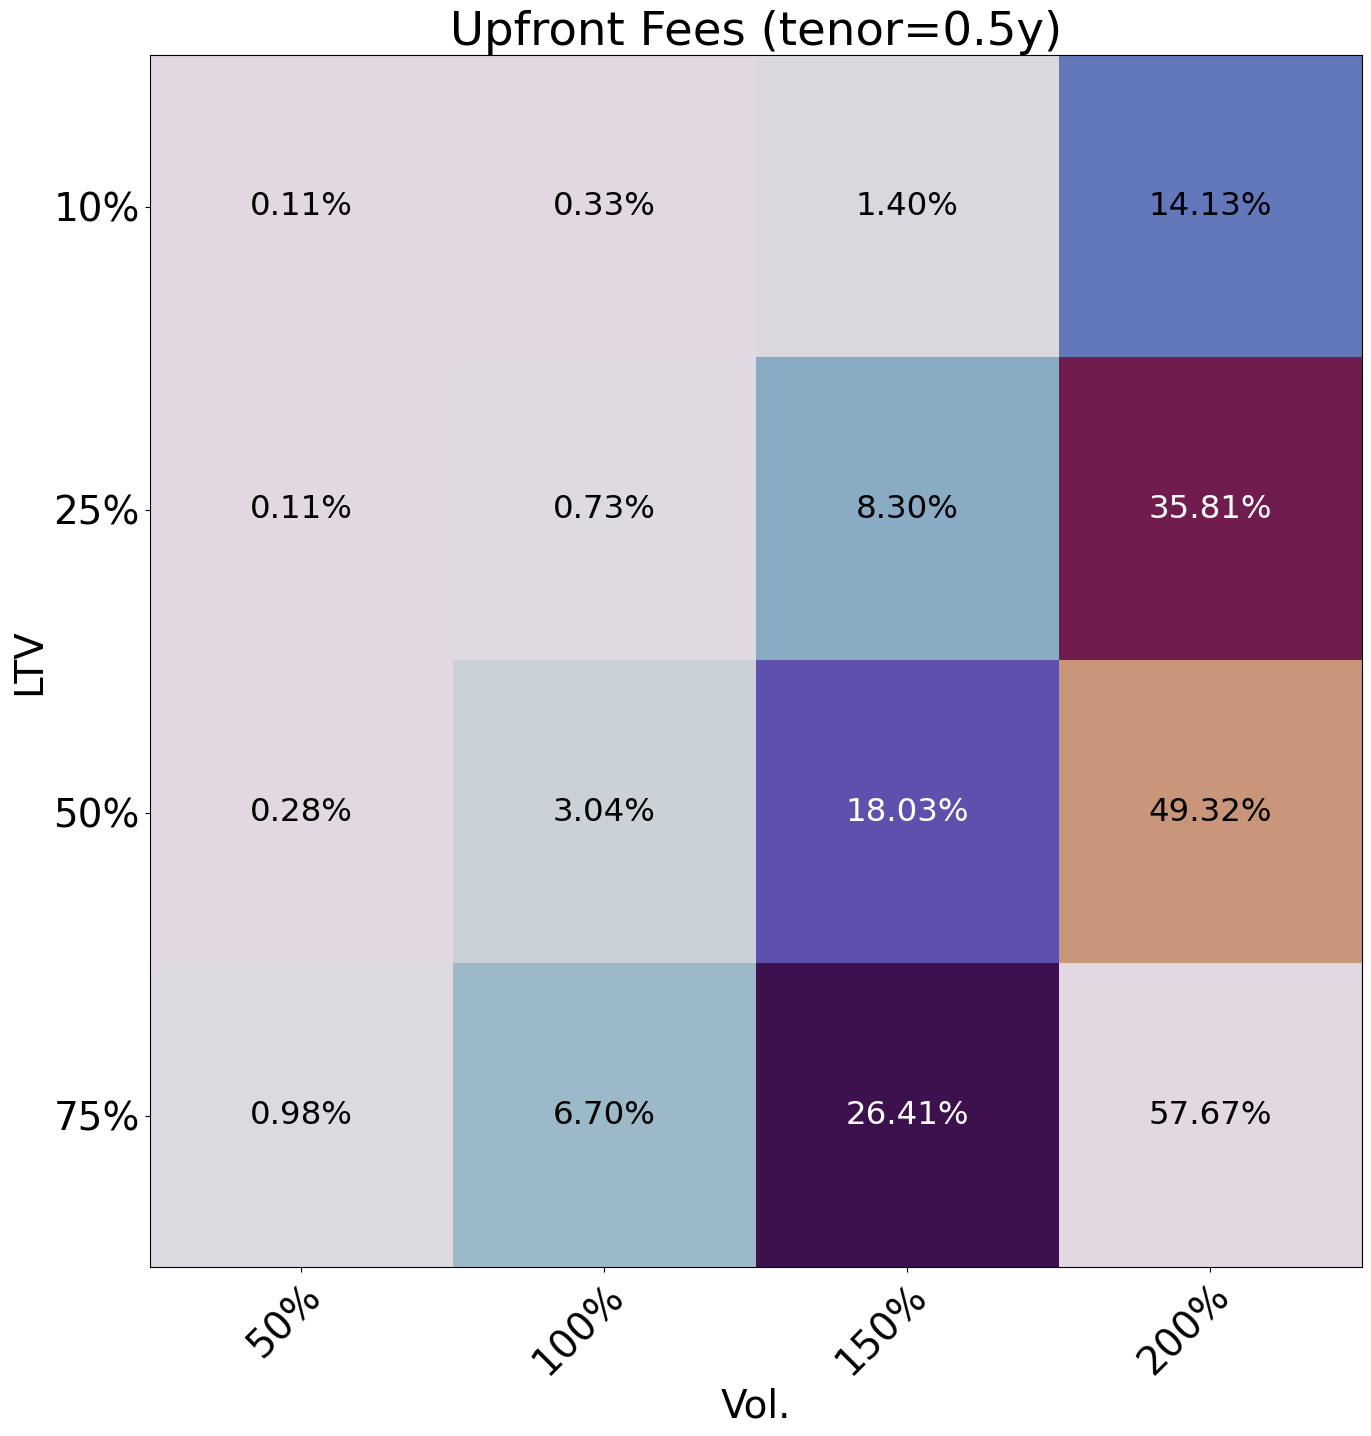

In [4]:
import numpy as np
from scipy.stats import norm
from scipy import optimize

def getD1(S, K, vol, dt, r):
    return (np.log(S / K) + (r + vol**2 / 2) * dt) / \
        (vol * np.sqrt(dt))

def getCallPrice(spotPrice, strikePrice, vol, dt,riskFreeRate):
    if dt <= 0:
        return max([0, spotPrice - strikePrice])
    if strikePrice <= 0:
        return spotPrice
    d1 = getD1(spotPrice, strikePrice, vol, dt, riskFreeRate)
    d2 = d1 - vol * np.sqrt(dt)
    value = spotPrice * norm.cdf(d1) - strikePrice * \
        np.exp(-riskFreeRate * dt) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return value, delta

def getEquilibriumFee(loanAmount, spotPrice, vol, riskFreeRate, loanTenorInYears):
    def getSwapValue(fee):
        callPrice, _ = getCallPrice(spotPrice, loanAmount, vol, loanTenorInYears, riskFreeRate)
        swapValue = -1*spotPrice + loanAmount + callPrice*(1-fee)
        return swapValue
    
    def minFunc(fee):
        swapValue = getSwapValue(fee)
        return swapValue**2

    initFeeGuess = .5
    feeBnds = (.0, 1.)
    res = optimize.minimize(
        minFunc,
        args=(),
        x0=[initFeeGuess],
        bounds=[feeBnds])
        
    callPrice, callDelta = getCallPrice(spotPrice, loanAmount, vol, loanTenorInYears, riskFreeRate)
    intrinsicVal = max([spotPrice - loanAmount, 0])
    timeVal = callPrice - intrinsicVal
    
    if res["success"] and res["fun"] < 0.1:
        fee = res['x'][0]
    else:
        fee = None
        
    return fee, callPrice, intrinsicVal, timeVal, callDelta

if __name__ == "__main__":
    params = {
        "loanAmount": 10.,
        "spotPrice": 30.,
        "vol": 1.5,
        "riskFreeRate": .02,
        "loanTenorInYears": 1./2
    }
    
    print("ltv; vol; loanAmount; fee; reclaimable; callValue; intrinsicVal; timeVal; callDelta")
    feeRes = []
    vols = [.5, 1., 1.5, 2.]
    ltvs = [.1, .25, .5, .75]
    for vol in vols:
        tmp = []
        params["vol"] = vol
        for ltv in ltvs:
            params["loanAmount"] = params["spotPrice"]*ltv
            (fee, callPrice, intrinsicVal, timeVal, callDelta) = getEquilibriumFee(**params)
            tmp.append(fee)
            print("{:.2f}%; {:.2f}%; {:.2f}; {:.2f}%; {:.2f}; {:.2f}; {:.2f}; {:.2f}; {:.2f}".format(ltv*100, vol*100, params["loanAmount"], fee*100, 1-fee, callPrice, intrinsicVal, timeVal, callDelta))
        feeRes.append(tmp)
    print(feeRes)
    
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 28})
    fig, ax = plt.subplots(figsize=(15, 15))
    CMAP = "twilight"
    cmap = plt.cm.get_cmap(CMAP)
    im = ax.imshow(feeRes, cmap=CMAP)
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(vols)), labels=["{:.0f}%".format(x*100) for x in vols])
    ax.set_yticks(np.arange(len(ltvs)), labels=["{:.0f}%".format(x*100) for x in ltvs])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    normColors = plt.cm.colors.Normalize(vmin=np.min(feeRes), vmax=np.max(feeRes))
    for i in range(len(ltvs)):
        for j in range(len(vols)):
            bg = cmap(normColors(feeRes[i][j]))
            v = 0 if (bg[0] + bg[1] + bg[2]) / 3 > 0.5 else 1
            c = (v, v, v, 1.)
            text = ax.text(j, i, "{:.2f}%".format(feeRes[i][j]*100),
                           ha="center", va="center", color=c, fontsize="smaller")
    
    ax.set_title("Upfront Fees (tenor={:.1f}y)".format(params["loanTenorInYears"]))
    ax.set_ylabel("LTV")
    ax.set_xlabel("Vol.")
    fig.tight_layout()
    plt.show()
